In [14]:
import pandapower as pp
import pandapower.networks as pn

import shap
import torch
import numpy as np
import math
import pandas as pd
from itertools import combinations


import copy
import time

In [10]:
class shapley_calc:
    def __init__(self, net):
        self.net = net
        self.load_num = len(self.net.load)
        self.sgen_num = len(self.net.sgen)
        self.total_player_num = self.load_num+self.sgen_num

    def coalitional_value(self, coalition): # TRUE FALSE COALITION
        self.copy_net = copy.deepcopy(self.net)
        
        # SEPARATE BOOL INDEX
        self.load_bool_idx = coalition[:self.load_num]
        self.sgen_bool_idx = coalition[self.load_num:self.total_player_num]

        self.update_load_list = np.zeros(self.load_num)
        for i, value in enumerate(self.load_bool_idx):
            if value == True:
                self.update_load_list[i] = self.copy_net.load.p_mw[i]
            elif value == False:
                self.update_load_list[i] = 0

        self.update_sgen_list = np.zeros(self.sgen_num)
        for i, value in enumerate(self.sgen_bool_idx):
            if value == True:
                self.update_sgen_list[i] = self.copy_net.sgen.p_mw[i]
            elif value == False:
                
                self.update_sgen_list[i] = 0

        # UPDATE DATA
        self.copy_net.load.p_mw = self.update_load_list
        self.copy_net.sgen.p_mw = self.update_sgen_list

        pp.runpp(self.copy_net)

        return sum(self.copy_net.res_line.pl_mw)

    def component_shapley(self, player):
        self.shapley = 0
        for coalition_number in range(self.total_player_num):
            #print("coal_number : ", coalition_number)
            
            self.numbering_index = list(range(self.total_player_num))
            self.numbering_index.remove(player)

            self.without_i_coalition_list = list(combinations(self.numbering_index, coalition_number))

            for players in list(self.without_i_coalition_list):
                self.bool_list_w_player=np.zeros(self.total_player_num)
                self.bool_list_wo_player=np.zeros(self.total_player_num)
                
                for indexing_number in range(self.total_player_num):
                    if indexing_number in players:
                        self.bool_list_w_player[indexing_number] = True
                        self.bool_list_wo_player[indexing_number] = True
                    else:
                        self.bool_list_w_player[indexing_number] = False
                        self.bool_list_wo_player[indexing_number] = False
                    
                    self.bool_list_w_player[player] = True
                    self.bool_list_wo_player[player] = False

                '''print('coalition_number_wo_player : ',coalition_number)
                print('player : ', player)
                print('bool_w_player : ', self.bool_list_w_player)
                print('bool_wo_player : ', self.bool_list_wo_player)'''

                self.weight = math.factorial(coalition_number)*math.factorial(self.total_player_num-coalition_number-1)/math.factorial(self.total_player_num)
                self.marginal_value = self.coalitional_value(self.bool_list_w_player)-self.coalitional_value(self.bool_list_wo_player)
                self.shapley += self.weight * self.marginal_value
        
        return self.shapley
    
    def shapley_list(self):
        self.shapley_list = np.zeros(self.total_player_num)
        for player in range(self.total_player_num):
            self.shapley_list[player] = self.component_shapley(player=player)
        
        return self.shapley_list

In [19]:
net = pn.panda_four_load_branch()
data_number = 10

data = [0 for i in range(data_number)]

start = time.time()
for i in range(10):
    random_load_data = np.round(np.random.uniform(low=0, high=0.1, size=len(net.load)), 4)
    print(random_load_data)
    net.load.p_mw = random_load_data

    sv = shapley_calc(net)
    loss_shpley = np.array(sv.shapley_list())
    combined_arr = np.concatenate((random_load_data, loss_shpley))


    data[i] = combined_arr
end = time.time()

loss_allocation_data = pd.DataFrame(data)
print(loss_allocation_data)
print('calculation_time:',f"{end-start:.5f}")


[0.0342 0.0337 0.0819 0.0328]
[0.0441 0.0495 0.0852 0.0113]
[0.0347 0.0671 0.0662 0.0041]
[0.0928 0.0179 0.0143 0.0782]
[0.0002 0.0872 0.0367 0.0056]
[0.0621 0.0394 0.0306 0.0794]
[0.0629 0.0329 0.0843 0.0364]
[0.0313 0.0045 0.0939 0.0227]
[0.0889 0.0163 0.0477 0.0587]
[0.07   0.0613 0.0531 0.0914]
        0       1       2       3         4         5         6         7
0  0.0342  0.0337  0.0819  0.0328  0.000488  0.000873  0.002830  0.001235
1  0.0441  0.0495  0.0852  0.0113  0.000652  0.001295  0.002848  0.000396
2  0.0347  0.0671  0.0662  0.0041  0.000461  0.001594  0.001930  0.000123
3  0.0928  0.0179  0.0143  0.0782  0.001460  0.000441  0.000460  0.002944
4  0.0002  0.0872  0.0367  0.0056  0.000002  0.001708  0.000844  0.000132
5  0.0621  0.0394  0.0306  0.0794  0.001032  0.001124  0.001147  0.003431
6  0.0629  0.0329  0.0843  0.0364  0.001068  0.000962  0.003237  0.001523
7  0.0313  0.0045  0.0939  0.0227  0.000371  0.000096  0.002813  0.000734
8  0.0889  0.0163  0.0477  0.0587 

In [89]:
net = pn.panda_four_load_branch()
data_number = 10000

data = [0 for i in range(data_number)]

start = time.time()
for i in range(data_number):
    random_load_data = np.round(np.random.uniform(low=0, high=0.1, size=len(net.load)), 4)
    print(random_load_data)
    net.load.p_mw = random_load_data

    pp.runpp(net)
    line_loss_data = net.res_line.pl_mw.to_numpy()
    combined_arr = np.concatenate((random_load_data, line_loss_data))


    data[i] = combined_arr
end = time.time()

loss_allocation_data = pd.DataFrame(data)
print(loss_allocation_data)
print('calculation_time:',f"{end-start:.5f}")

[0.07   0.0617 0.0617 0.0244]
[0.0658 0.0538 0.0938 0.0971]
[0.0296 0.0772 0.049  0.0109]
[0.0211 0.0324 0.0538 0.0201]
[0.0222 0.0694 0.0309 0.0488]
[0.0035 0.018  0.0074 0.036 ]
[0.0645 0.0997 0.048  0.0565]
[0.0508 0.0633 0.067  0.0884]
[0.0416 0.0699 0.0284 0.031 ]
[0.0291 0.0807 0.0394 0.003 ]
[0.0073 0.0308 0.0003 0.0923]
[0.0125 0.0339 0.0854 0.0841]
[0.0569 0.075  0.0399 0.089 ]
[0.0236 0.0663 0.0584 0.0273]
[0.0696 0.0337 0.0903 0.0325]
[0.065  0.003  0.0263 0.0356]
[0.0861 0.086  0.0684 0.0828]
[0.05   0.0315 0.0006 0.0217]
[0.0608 0.0732 0.0197 0.0444]
[0.0752 0.0265 0.0261 0.097 ]
[0.0061 0.0104 0.0581 0.0846]
[0.0453 0.0218 0.0926 0.0498]
[0.0394 0.0727 0.0157 0.0997]
[0.0219 0.0137 0.0555 0.0564]
[0.0243 0.016  0.0814 0.0168]
[0.0799 0.0354 0.0908 0.0071]
[0.0978 0.0666 0.0881 0.0893]
[0.0176 0.0288 0.0928 0.0306]
[0.0874 0.0093 0.0516 0.0789]
[0.0287 0.0926 0.0341 0.0159]
[0.0454 0.0149 0.039  0.0927]
[0.0655 0.0766 0.0277 0.0596]
[0.0014 0.0506 0.0531 0.0216]
[0.0602 0.

In [90]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm

from numpy import NaN, NAN, nan

False

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [91]:
X_train, X_test, y_train, y_test = train_test_split(loss_allocation_data.iloc[:,:len(net.load)],
                                                    loss_allocation_data.iloc[:,len(net.load):],
                                                    test_size=0.2, random_state=42)

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
class TabularDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__(self):
        return len(self.X_data)

In [102]:
train_dataset = TabularDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train.to_numpy()))
test_dataset = TabularDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy()))

train_loader = DataLoader(dataset=train_dataset, batch_size=64)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [103]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 128)
        self.layer_2 = nn.Linear(128, 120)
        self.layer_3 = nn.Linear(120, 120)
        self.layer_4 = nn.Linear(120, 120)
        self.layer_5 = nn.Linear(120, 120)
        self.layer_out = nn.Linear(120, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return x

In [104]:
model = NeuralNet(X_train.shape[1], y_train.shape[1])
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [105]:
epochs = 10000
for epoch in tqdm(range(epochs)):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

  1%|          | 99/10000 [00:17<28:22,  5.81it/s]


KeyboardInterrupt: 

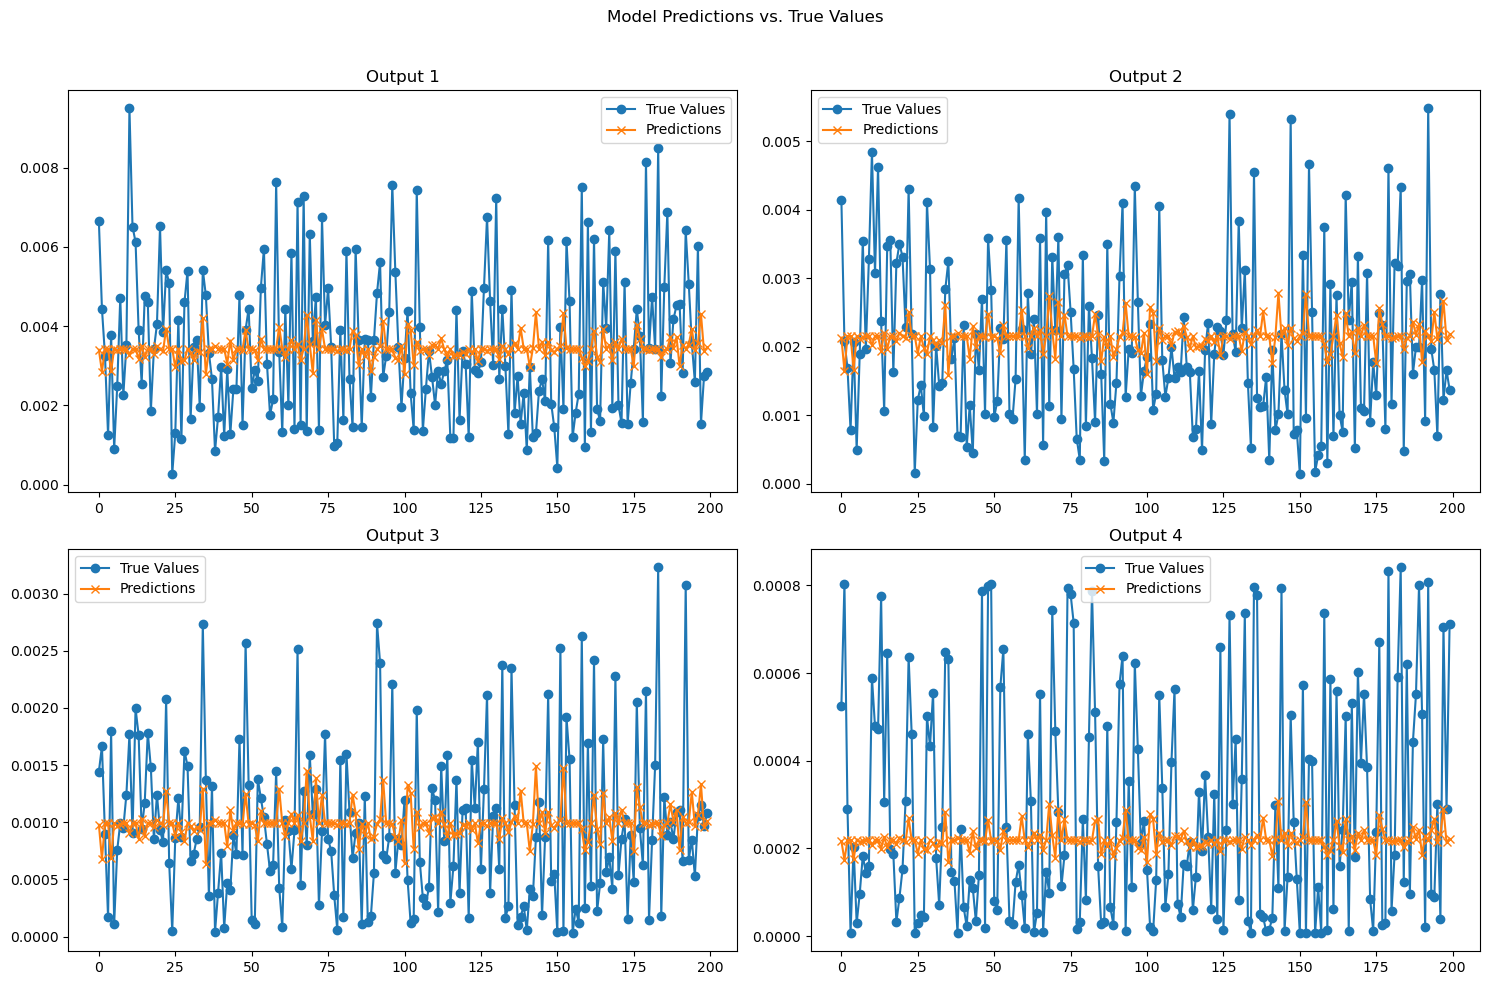

In [ ]:
import matplotlib.pyplot as plt

# Get all predictions and true values for test data
all_predictions = []
all_true_values = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        all_predictions.append(predictions)
        all_true_values.append(y_batch)

# Convert lists to tensors for easier indexing
all_predictions = torch.cat(all_predictions, dim=0)
all_true_values = torch.cat(all_true_values, dim=0)

# Plot the results for each output
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Predictions vs. True Values')

for i, ax in enumerate(axes.ravel()):
    ax.plot(all_true_values[:, i], label='True Values', marker='o')
    ax.plot(all_predictions[:, i], label='Predictions', marker='x')
    ax.set_title(f"Output {i+1}")
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


In [65]:
loss_allocation_data.to_csv("loss_allocation_data.csv")